<a href="https://colab.research.google.com/github/ToonToonToon/229352-Statical-Learning-For-DataScience-2/blob/main/Lab09_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Statistical Learning for Data Science 2 (229352)
#### Instructor: Donlapark Ponnoprat

#### [Course website](https://donlapark.pages.dev/229352/)

## Lab #9

In [1]:
%%capture
!git clone https://github.com/donlapark/ds352-labs.git

In [2]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

## Training a neural network in PyTorch

### Chihuahua or Muffin?

<center><img src="https://donlapark.pages.dev/229352/lab09-preview.jpg" width="500"/></center>

### 1. Data preparation

#### Load images, resize them to 128x128, and normalize the pixels to be in 0 - 1 range

In [3]:
transform = transforms.Compose([transforms.Resize((128, 128)),
                                transforms.ToTensor()])  # transform pixels to be in 0 - 1 range

dataset = datasets.ImageFolder(root="ds352-labs/lab09-data/train",
                                         transform=transform)

#### Split the dataset into training (80%), validation (20%)

In [4]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

#### Load the datasets into DataLoader

In [5]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=10,
                          shuffle=True)
val_loader = DataLoader(dataset=val_dataset,
                        batch_size=len(val_dataset),
                        shuffle=False)

#### Do the same for the test images

In [6]:
test_dataset = datasets.ImageFolder(root="ds352-labs/lab09-data/test",
                                    transform=transform)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=len(test_dataset),
                         shuffle=False)

#### Looking at the first minibatch

In [7]:
train_batches = iter(train_loader)
X, y = next(train_batches)

print(X.shape)  # (batch_size, channel, height, weight)
print(y.shape)

torch.Size([10, 3, 128, 128])
torch.Size([10])


#### Visualize the first four images in the batch

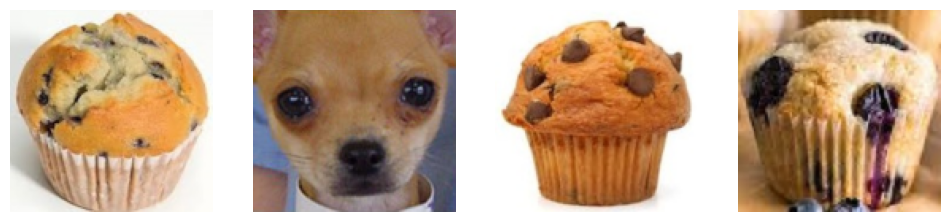

tensor([1, 0, 1, 1])


In [8]:
X = X[:4]  # Select the first 4 images
X = X.numpy().transpose(0, 2, 3, 1)  # Convert from (B, C, H, W) to (B, H, W, C)

# Plot images
fig, axes = plt.subplots(1, 4, figsize=(12, 4))
for i in range(4):
    axes[i].imshow(X[i])
    axes[i].axis('off')
plt.show()

print(y[:4])

### 2. Build a simple logistic regression

<center><img src="https://donlapark.pages.dev/229352/logistic.png" width="300"/></center>

The most important component of the model class is the `__init__` method and the `forward` method.  

[Linear layer in Pytorch](https://docs.pytorch.org/docs/stable/generated/torch.nn.Linear.html)

[Activation functions in PyTorch](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity). The most important ones are [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html), [Sigmoid](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html), [Softmax](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html), [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html).

In [11]:
class SimpleLogisticRegression(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.lin1 = nn.Linear(128 * 128 * 3,100)
    self.act1 = nn.ReLU()
    self.lin2 = nn.Linear(100, 50)
    self.act2 = nn.ReLU()
    self.lin3 = nn.Linear(50, 1)

  def forward(self, x):
    x = self.flatten(x)
    x = self.lin1(x)
    x = self.act1(x)
    x = self.lin2(x)
    x = self.act2(x)
    x = self.lin3(x)
    return x

### 3. Initialize training components

#### Initialize the model and loss function

[Loss functions in PyTorch](https://pytorch.org/docs/stable/nn.html#loss-functions). Most important ones are [MSE](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html), [Binary cross, entropy](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html), [Categorical cross entropy](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).

In [30]:
model = SimpleLogisticRegression()
criterion = nn.CrossEntropyLoss()

#### Manually setting initial weights to zero for demonstration

In [14]:
with torch.no_grad():
  for layer in model.modules():
      if isinstance(layer, nn.Linear):
          layer.weight.zero_()
          layer.bias.zero_()

#### Create two lists to collect training and validation losses

In [15]:
# List to store the loss values for plotting
train_losses = []
val_losses = []

#### Specify the learning rate

In [16]:
learning_rate = 1e-3
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

### 4. Training the model with gradient descent

#### Convert the dataloader into minibatches

In [17]:
X , y = next(iter(train_batches))

#### Make a prediction on the minibatch (Forward pass)

In [18]:
y_hat = model(X)
y = y.to(torch.float32)
y_hat = y_hat[:, 0]

#y_hat = y_hat[:, 0]
#y = y.to(torch.float32)

#### Calculate the loss function

Recall that `criterion()` is our binary cross-entropy loss (`BCELoss`).

In [19]:
# Compute the loss
train_loss = criterion(y_hat, y)
train_losses.append(train_loss.item())

In [20]:
train_losses

[13.815511703491211]

#### Calculate the gradient (Backward pass)

In [21]:
# Backward pass: compute the gradient of the loss w.r.t. model parameters
train_loss.backward()

In [22]:
model.parameters()

<generator object Module.parameters at 0x7e4f0937b680>

#### Perform a gradient descent step

Careful! We must not include this step in the gradient calculation, hence the use of `with torch.no_grad()`.

In [23]:
# Update the weights using the gradient descent rule
optimizer.step() # parameter - learining rate * gradient_of_parameters

# Zero the gradients after updating
model.zero_grad()

#### Do the same for the validation set

Careful! Anything in the validation step must not be included in the gradient calculation, hence the use of `with torch.no_grad()`.

In [24]:
with torch.no_grad():
  for X, y in val_loader:
    y_hat = model(X)
    y_hat = y_hat[:, 0]
    y = y.to(torch.float32)
    print(y_hat, y)
    val_loss = criterion(y_hat, y)
    val_losses.append(val_loss.item())

tensor([3.5763e-10, 3.5763e-10, 3.5763e-10, 3.5763e-10, 3.5763e-10, 3.5763e-10,
        3.5763e-10, 3.5763e-10, 3.5763e-10, 3.5763e-10, 3.5763e-10, 3.5763e-10,
        3.5763e-10, 3.5763e-10, 3.5763e-10, 3.5763e-10, 3.5763e-10, 3.5763e-10,
        3.5763e-10, 3.5763e-10, 3.5763e-10, 3.5763e-10, 3.5763e-10, 3.5763e-10]) tensor([0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1.,
        0., 0., 0., 1., 1., 0.])


In [25]:
print(train_losses)
print(val_losses)

[13.815511703491211]
[31.780536651611328]


#### Combine everything together.

Repeat the previous steps for 20 **epochs** and plot the training and validation losses.

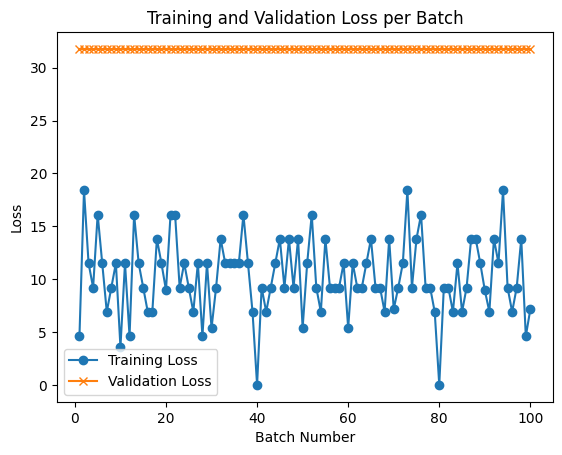

In [27]:
model = SimpleLogisticRegression()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

with torch.no_grad():
  for layer in model.modules():
      if isinstance(layer, nn.Linear):
          layer.weight.zero_()
          layer.bias.zero_()

train_losses = []
val_losses = []

learning_rate = 1e-4

for epoch in range(10):
  for X, y in train_loader:
    y_hat = model(X)
    y_hat = y_hat[:, 0]
    y = y.to(torch.float32)

    loss = criterion(y_hat, y)
    train_losses.append(loss.item())

    loss.backward()
    optimizer.step()

    # Zero the gradients after updating
    model.zero_grad()

    with torch.no_grad():
      for X, y in val_loader:
        y_hat = model(X)
        y_hat = y_hat[:, 0]
        y = y.to(torch.float32)
        val_loss = criterion(y_hat, y)
        val_losses.append(val_loss)

# Plot the training and validation loss
plt.plot(range(1, len(train_losses)+1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, marker='x', label='Validation Loss')
plt.title('Training and Validation Loss per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Exercise

In this exercise, we will add more layers to our classification model.

<img src="https://donlapark.pages.dev/229352/lab09-architecture.png" width="450"/>

1. Create a neural network with 3 hidden layers as shown in the picture.

2. Train the model with learning rate = 1e-2, 1e-3, 1e-4, 1e-5, and answer the following questions.
    2.1 What value of learning rate do you **think** is the best? Please explain your reason.
    2.2 What happens to the training losses if your learning rate is too large?
    2.3 What happens to the training losses if your learning rate is too small?

3. After finish training your model. Make the predictions on the test set and compute the accuracy. You may use the provided code below.

4. Use `plt.imshow()` to display at least four images that are incorrectly classified by this model.

In [31]:
class PetClassifier(nn.Module):
    def __init__(self):
        super(PetClassifier, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(3 * 128 * 128, 128) ฏ
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.sigmoid(self.fc4(x))
        return x

model = PetClassifier()
print(model)

PetClassifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=49152, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


In [37]:
learning_rates = [1e-2, 1e-3, 1e-4, 1e-5]
criterion = nn.BCELoss()

accuracies = {}

for lr in learning_rates:
    print(f"--- Training with Learning Rate: {lr} ---")
    model = PetClassifier()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    num_epochs = 5
    for epoch in range(num_epochs):
        for images, labels in train_loader:
            outputs = model(images)
            loss = criterion(outputs, labels.float().unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    print(f"Finished training for LR {lr}")

    num_correct = 0
    num_samples = 0
    model.eval()
    with torch.no_grad():
        for X, y in test_loader:
            y_hat = model(X)
            y_hat = y_hat[:, 0]
            predictions = (y_hat > 0.5).float()
            num_correct += (predictions == y).sum().item()
            num_samples += y.size(0)
    accuracy = num_correct / num_samples
    accuracies[lr] = accuracy * 100
    model.train()

print("\n--- Accuracies for each Learning Rate ---")
for lr, acc in accuracies.items():
    print(f"Learning Rate: {lr}, Accuracy: {acc:.2f}%")


--- Training with Learning Rate: 0.01 ---
Finished training for LR 0.01
--- Training with Learning Rate: 0.001 ---
Finished training for LR 0.001
--- Training with Learning Rate: 0.0001 ---
Finished training for LR 0.0001
--- Training with Learning Rate: 1e-05 ---
Finished training for LR 1e-05

--- Accuracies for each Learning Rate ---
Learning Rate: 0.01, Accuracy: 43.33%
Learning Rate: 0.001, Accuracy: 80.00%
Learning Rate: 0.0001, Accuracy: 70.00%
Learning Rate: 1e-05, Accuracy: 70.00%


In [38]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        test_batches = iter(loader)
        for X, y in loader:

            y_hat = model(X)
            y_hat = y_hat[:, 0]
            predictions = (y_hat > 0.5).float()

            num_correct += (predictions == y).sum().item()
            num_samples += y.size(0)

    accuracy = num_correct / num_samples
    print(f'Accuracy: {accuracy*100:.2f}%')
    model.train()

check_accuracy(test_loader, model)

Accuracy: 70.00%


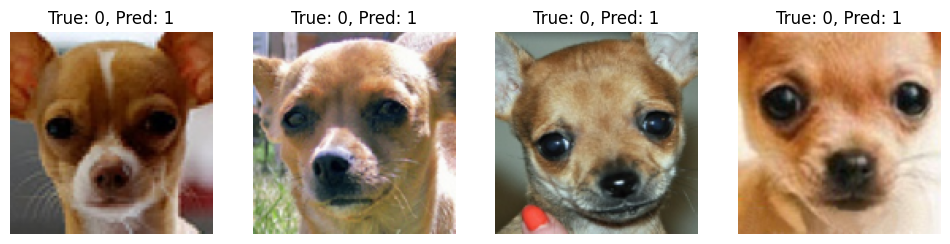

In [39]:
def show_errors(loader, model):
    model.eval()
    wrong_images = []
    wrong_labels = []
    predicted_labels = []

    with torch.no_grad():
        for X, y in loader:
            y_hat = model(X)
            y_hat = y_hat[:, 0]
            preds = (y_hat > 0.5).float()

            errors = (preds != y)

            if errors.sum() > 0:
                wrong_X = X[errors]
                wrong_y = y[errors]
                wrong_preds = preds[errors]

                for i in range(len(wrong_X)):
                    wrong_images.append(wrong_X[i])
                    wrong_labels.append(wrong_y[i])
                    predicted_labels.append(wrong_preds[i])

                    if len(wrong_images) >= 4:
                        break
            if len(wrong_images) >= 4:
                break

    fig, axes = plt.subplots(1, 4, figsize=(12, 3))
    for i in range(4):
        img = wrong_images[i].permute(1, 2, 0).cpu().numpy()
        axes[i].imshow(img)
        axes[i].set_title(f"True: {int(wrong_labels[i])}, Pred: {int(predicted_labels[i])}")
        axes[i].axis('off')
    plt.show()

show_errors(test_loader, model)